# 前言

APM因子的构建思想在于股票价格行为存在日内模式差异。

在A股市场中，市场微观结构领域的实证研究显示，知情交易概率（probability of informed trading）在日内呈现“倒J形”曲线。关于这个现象的简单理解是：由于隔夜时段的交易暂停，每个交易日开盘后，市场累积的大量私有信息，将通过交易迅速释放，因此知情交易概率在开盘后呈现快速下降的形态。换言之，知情交易者更加倾向于在每日上午进行交易，上午的价格行为蕴藏了更多可用于选股的信息量。我 们独家提出的APM因子模型，专注于考察上午（am）与下午（pm）的价格行为差异，并提取出有效的选股因子。

In [1]:
# 引入库
import sys
sys.path.append('../../..')

from BuildPeriodDate import (GetTradePeriod,tdaysoffset)

import numpy as np
import pandas as pd
import empyrical as ep
import alphalens as al
from scipy import stats
import statsmodels.api as sm


from alphalens.utils import quantize_factor  # 因子分组


from jqdata import *

import datetime as dt
import itertools
from functools import reduce
from tqdm import tqdm_notebook
from dateutil.parser import parse
from typing import (Tuple,List,Union,Dict,Callable)

# 画图相关
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # 划分子图

from alphalens import plotting
import alphalens.performance as perf

mpl.rcParams['font.family']='serif' # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

In [2]:
# 筛选股票池
class get_stock_pool(object):
    
    def __init__(self,symbol:str,watch_date:str)->None:
        
        if isinstance(watch_date,str):
            
            self.watch_date = parse(watch_date).date()
            
        else:
            
            self.watch_date = watch_date
            
        self.symbol = symbol
        
    def get_index_component_stocks(self)->list:
        
        '''获取指数成分股'''
        
        if self.symbol == 'A':
            
            self.stocks = get_all_securities(types=['stock'],date=self.watch_date)
            self.stocks = self.stocks.query('end_date != "2200-01-01"').index.tolist()
        else:
            
            self.stocks = get_index_stocks(self.symbol,self.watch_date)
    
    def filter_paused(self,paused_N:int=1,threshold:int=None)->list:
        
        '''过滤停牌股
        -----
        输入:
            paused_N:默认为1即查询当日不停牌
            threshold:在过paused_N日内停牌数量小于threshold
        '''
        
        if (threshold is not None) and (threshold > paused_N):
            raise ValueError(f'参数threshold天数不能大于paused_N天数')
            
        
        paused = get_price(self.stocks,end_date=self.watch_date,count=paused_N,fields='paused',panel=False)
        paused = paused.pivot(index='time',columns='code')['paused']
        
        # 如果threhold不为None 获取过去paused_N内停牌数少于threshodl天数的股票
        if threshold is not None:
            
            sum_paused_day = paused.sum()
            self.stocks = sum_paused_day[sum_paused_day < threshold].index.tolist()
        
        else:
            
            paused_ser = paused.iloc[-1]
            self.stocks = paused_ser[paused_ser == 0].index.tolist()
    
    def filter_st(self)->list:
        
        '''过滤ST'''
              
        extras_ser = get_extras('is_st',self.stocks,end_date=self.watch_date,count=1).iloc[-1]
        
        self.stocks = extras_ser[extras_ser == False].index.tolist()
    
    def filter_ipodate(self,threshold:int=180)->list:
        
        '''
        过滤上市天数不足以threshold天的股票
        -----
        输入：
            threhold:默认为180日
        '''
        
        def _check_ipodate(code:str,watch_date:dt.date)->bool:
            
            code_info = get_security_info(code)
            
            if (code_info is not None) and ((watch_date - code_info.start_date).days > threshold):
                
                return True
            
            else:
                
                return False

        self.stocks = [code for code in self.stocks if _check_ipodate(code,self.watch_date)]

In [22]:
# 因子数据准备
def prepare_factor(symbol: str,
                   start: str,
                   end: str,
                   freq='W') -> pd.DataFrame:

    periods = GetTradePeriod(start, end, freq)

    factors = ['apm_raw', 'apm_new', 'apm_1', 'apm_2', 'apm_3']

    factor_dic = {}

    for trade in tqdm_notebook(periods, desc='因子计算中'):

        # 获取股票池
        stock_pool_func = get_stock_pool(symbol, trade)
        stock_pool_func.get_index_component_stocks()  # 获取基础股票池
        stock_pool_func.filter_paused(22, 21)  # 过滤22日停牌超过21日的股票
        stock_pool_func.filter_st()  # 过滤st
        stock_pool_func.filter_ipodate()  # 过滤次新

        # 因子计算
        factor = APM(stock_pool_func.stocks, '000905.XSHG', trade, 20)
        # 获取五种不同的因子构造
        factor_df = pd.concat((factor.calc_factor(i) for i in factors), axis=1)
        factor_df.columns = factors
        factor_dic[trade] = factor_df

    df = pd.concat(factor_dic, names=['date', 'code'])

    return df


'''回测相关'''


def get_algoritm_returns(score_df: pd.DataFrame,
                         last_date: str,
                         handle_num: int = 10) -> pd.DataFrame:
    '''
    获取各个因子合成方法的收益率序列
    ------
    输入参数:
        handle_num:持仓数量
    '''

    # 根据因子得分 获取收益率数据
    #next_ret = get_next_returns(score_df,last_date)

    returns_dic = {}  # 收益率储存容器

    for col, ser in score_df.items():

        cond = ser.groupby(
            level='date',
            group_keys=False).apply(lambda x: x.nlargest(handle_num))
        #returns_dic[col] = next_ret.loc[cond.index,'next_ret'].groupby(level='date').mean()
        returns_dic[col] = get_daily_pct(cond, last_date)['next_ret']

    ret = pd.concat(returns_dic, axis=1)  # 组合收益率

    return ret


def get_next_returns(factor_df: pd.DataFrame,
                     last_date: str = None) -> pd.DataFrame:
    '''
    获取下期收益率
    ------
    输入:
        factor_df:MuliIndex-level0-datetime.date level1-code columns - factors
        last_date:最后一期时间
    ------
    return pd.DataFrame
           MuliIndex level0-date level1-code value-next_ret
    '''
    if last_date:
        days = pd.to_datetime(
            factor_df.index.get_level_values('date').unique().tolist() +
            [last_date])
    else:
        days = pd.to_datetime(
            factor_df.index.get_level_values('date').unique().tolist())

    dic = {}
    for s, e in zip(days[:-1], days[1:]):

        stocks = factor_df.loc[s.date()].index.get_level_values(
            'code').unique().tolist()

        a = get_price(stocks, end_date=s, count=1, fields='close',
                      panel=False).set_index('code')['close']

        b = get_price(stocks, end_date=e, count=1, fields='close',
                      panel=False).set_index('code')['close']

        dic[s] = b / a - 1

    df = pd.concat(dic).to_frame('next_ret')

    df.index.names = ['date', 'code']
    return df


def build_factor_data(factor_data: pd.DataFrame, returns: pd.DataFrame,
                      quantile: int) -> Dict:
    '''
    构造为alphalens通用的数据格式
    ------
    输入参数:
        factor_data:MuliIndex level0-date level1-code columns-因子名称
        returns:下期收益率get_next_returns的结果
    ------
    return Dict
           key-因子名称 
           values-pd.DataFrame 其中 MuliIndex level0-date level1-code columns:factor|factor_quantile|1
           1就是next_returns
    '''
    def add_group(ser: pd.Series, quantile: int) -> pd.Series:

        factor_data = ser.to_frame('factor')

        return quantize_factor(factor_data, quantiles=quantile)

    def df_concat(df_list: Union[list, tuple]) -> pd.DataFrame:
        df = pd.concat(df_list, axis=1)
        df.columns = ['factor', 1, 'factor_quantile']
        df.index.names = ['date','asset']
        return df
    
    return {
        i: df_concat(
            (factor_data[i], returns, add_group(factor_data[i], quantile)))
        for i in factor_data.columns
    }


def get_factor_group_return(factor_df: pd.DataFrame) -> pd.DataFrame:
    '''
    获取因子的N分位收益
    ------
    输入参数:
        factor_df:MuliIndex level0-date level1-code columns:factor|factor_quantile|1
    '''

    return pd.pivot_table(factor_df.reset_index(),
                          index='date',
                          columns='factor_quantile',
                          values=1)


'''画图'''


def plot_algorithm_periods_nav(returns: pd.DataFrame, benchmark: pd.DataFrame,
                               **kwg):
    '''
    画策略分年度与基准的比较情况
    '''
    return_dic = {
        year.year: ser
        for year, ser in returns.groupby(pd.Grouper(level='date', freq='Y'))
    }

    size = len(return_dic)

    col_num = 2
    row_num = math.ceil(size / col_num)

    mpl.rcParams['font.family'] = 'serif'

    fig, axes = plt.subplots(row_num,
                             col_num,
                             figsize=(8 * col_num, 4 * row_num))
    axes = [i for k in axes for i in k]

    i = 0
    for ax, (year, ser) in zip(axes, return_dic.items()):

        idx = ser.index
        slice_benchmark = benchmark.loc[idx]
        benchmark_nav = (slice_benchmark['close'] /
                         slice_benchmark['close'][0])
        cum = ep.cum_returns(ser, starting_value=1)

        ax.set_title(f'{year}年净值表现')
        ax.set_ylabel('净值')
        benchmark_nav.plot(ax=ax, label='HS300', color='darkgray', ls='--')
        cum.plot(ax=ax, label='净值', **kwg)
        ax.legend(loc='upper left')
        i += 1

    plt.subplots_adjust(hspace=0.5)

    return axes

'''IC计算'''

def get_information_table(ic_data:pd.DataFrame)->pd.DataFrame:
    
    '''获取因子IC相关信息'''
    
    ic_summary_table = pd.DataFrame()
    ic_summary_table["IC Mean"] = ic_data.mean()
    ic_summary_table["IC Std."] = ic_data.std()
    ic_summary_table["Risk-Adjusted IC"] = \
        ic_data.mean() / ic_data.std()
    t_stat, p_value = stats.ttest_1samp(ic_data, 0)
    ic_summary_table["t-stat(IC)"] = t_stat
    ic_summary_table["p-value(IC)"] = p_value
    ic_summary_table["IC Skew"] = stats.skew(ic_data)
    ic_summary_table["IC Kurtosis"] = stats.kurtosis(ic_data)
    
    return ic_summary_table

def factor_ttest(factor_df:pd.DataFrame)->pd.DataFrame:
    
    '''
    每期的T检验
    ------
    输入参数:
        factor_df:pd.DataFrame MuliIndex level0-date level1-code columns-factor|1|factor_quantile
    ------
    '''
    
    def calc_beta(x:pd.DataFrame,y:pd.Series)->pd.Series:
        
        res = stats.linregress(x, y)
        return res.rvalue
    
    beta = factor_df.groupby(level='date').apply(lambda x:calc_beta(x['factor'],x[1]))

    return beta.rolling(5).apply(lambda x:stats.ttest_1samp(x,0)[0],raw=True)


def get_ttest_table(t_value:pd.DataFrame)->pd.DataFrame:
    
    t_value_table = pd.Series()
    t_value_table['Abs T Mean'] = t_value.abs().mean()
    t_value_table['T Mean'] = t_value.mean()
    t_value_table['T > 2'] = len(t_value[t_value.abs() > 2]) / len(t_value)
    
    return t_value_table.to_frame('回归法检验')
    

# 因子构造方式


第一步：对选定股票，回溯取其获取20日数据,记逐日上午的股票收益率为$r^{am}_t$,指数收益率$R^{am}_t$；逐日下午的股票收益率为$r^{pm}_t$，指数收益率为$R^{pm}_t$;

第二步：将得到的40组上午与下午的收益率数据进行回归:

$$r_i = \alpha + \beta R_i + \epsilon_i$$

获得$\epsilon$;

第三步:以上得到40个残差$\epsilon_i$中，上午残差记为$\epsilon^{am}_t$,下午残差记为$\epsilon^{pm}_t$,进一步计算每日上午与下午残差的插值$\delta_t = \epsilon^{am}_t - \epsilon^{am}_t$;

第四步:构造统计计量stat来衡量上午与下午残差的差异程度，计算公式如下($\mu$为均值,$\sigma$为标准差):

$$stat = \frac{\mu(\delta_t)}{\sigma(\delta)/\sqrt{N}}$$

第五步:为了消除动量因子的影响,将统计量stat对动量因子进行横截面回归:$stat_j=bRet20_t+\epsilon_j$，其中Ret20为股票过去20日的收益率,代表动量因子;
第六步:上一步回归得到的残差值作为$APM_{raw}$因子

# APM因子方法论应用于不同时段的比较


|因子名称|时段1|时段2|
|--|--|--|
|$APM^{RAW}$|上午(9:30-11:30)|下午(13:00-15:00)|
|$APM^{NEW}$|隔夜|下午(13:00-15:00)|
|$APM_1$|隔夜|14:00-15:00|
|$APM_2$|9:30-10:30|14:00-15:00|
|$APM_3$|10:30-11:30|13:00-14:00|

In [38]:
# 因子构造
class APM(object):

    times = {
        '上午': ('10:00:00', '11:30:00'),  # 10:00-open,11:30-close
        '下午': ('13:30:00', '15:00:00'),  # 13:00-open,15:00-close
        'am1': ('10:00:00', '10:30:00'),  # 10:00-open,10:30-close
        'am2': ('11:00:00', '11:30:00'),  # 11:00-open,11:30-close
        'pm1':('14:30:00','15:00:00'),
        'pm2':('13:30:00','14:00:00')
    }

    def __init__(self,
                 securities: list,
                 benchmark: str,
                 watch_date: str,
                 max_window: int = 20) -> None:

        self.securities = securities
        self.benchmark = benchmark
        self.watch_date = watch_date
        self.max_window = max_window
        # 获取30m数据
        self.data = get_price(securities + [benchmark],
                              end_date=watch_date,
                              count=max_window * 8,
                              frequency='30m',
                              fields=['close', 'open'],
                              panel=False)
        self.close_df = pd.pivot_table(self.data,
                                       index='time',
                                       columns='code',
                                       values='close')
        self.open_df = pd.pivot_table(self.data,
                                      index='time',
                                      columns='code',
                                      values='open')
        # 日度收益率
        daily = get_price(securities,
                          end_date=watch_date,
                          count=max_window + 1,
                          fields='close',
                          panel=False)
        daily = pd.pivot_table(daily,
                               index='time',
                               columns='code',
                               values='close')
        self.daily_pct = np.log(daily / daily.shift(1)).iloc[1:].sum()

    def overnight_ret(self) -> pd.DataFrame:
        '''
        隔日收益率
        ------
        return MuliIndex level0-date level1-code
        '''
        price = get_price(self.securities + [self.benchmark],
                          end_date=self.watch_date,
                          count=self.max_window + 1,
                          fields=['close', 'open'],
                          panel=False)

        price = price.pivot(index='time', columns='code')

        ret = (price['open'] /
               price['close'].shift(1)).iloc[-self.max_window:]
        

        return ret

    def calc_resid(self,pos1:Tuple[str,str], pos2:Tuple[str,str]) -> Tuple[pd.Series, pd.Series]:
        
        
        if pos1 == '隔夜':
            am = self.overnight_ret()
        else:
            am = self._get_logret(pos1[0], pos1[1])
        pm = self._get_logret(pos2[0], pos2[1])

        return self.regression(am), self.regression(pm)

    def _get_logret(self, start: str, end: str) -> pd.DataFrame:
        '''
        获取收益率
        '''
        open_df = self.open_df.at_time(start)
        open_df.index = open_df.index.normalize()
        close_df = self.close_df.at_time(end)
        close_df.index = close_df.index.normalize()

        return np.log(close_df / open_df)

    def regression(self, log_ret: pd.DataFrame) -> pd.Series:

        x = log_ret[self.securities].unstack().reset_index(
            level=0).sort_index()
        x.columns = ['code', 'log_ret']
        x['benchmark'] = log_ret[self.benchmark]

        def _rls(df: pd.DataFrame) -> pd.Series:
            df = df.set_index('code')
            X = sm.add_constant(df['benchmark'])
            y = df['log_ret']
            mod = sm.OLS(y, X)
            res = mod.fit()

            return res.resid

        return x.groupby(level=0).apply(_rls)

    def calc_factor(self, method: str) -> pd.Series:
        
        
        method_dic = {'apm_raw':(self.times['上午'],self.times['下午']),
                     'apm_new':('隔夜',self.times['下午']),
                     'apm_1':('隔夜',self.times['pm1']),
                     'apm_2':(self.times['am1'],self.times['pm1']),
                     'apm_3':(self.times['am2'],self.times['pm2'])}

        am_resid, pm_resid = self.calc_resid(*method_dic[method])
        dif = am_resid - pm_resid

        stat_ = dif.groupby(level='code').apply(
            lambda x: (x.mean() * np.sqrt(len(x))) / x.std())

        stat_, dialy_pct = stat_.align(self.daily_pct)

        mod = sm.OLS(stat_, dialy_pct)
        res = mod.fit()

        return res.resid

- 时间区间：2014-01-01至2020-12-31
- 股票池:中证500，过滤22日停牌的股票，过滤ST，股票次新
- 因子未作标准化、中性化
- 分组采用升序，周度轮动

In [64]:
# factor_data = prepare_factor('000905.XSHG','2014-01-01','2020-12-31')

# # 储存
# factor_data.to_csv('APM.csv')

In [5]:
# 读取
factor_data = pd.read_csv('APM.csv',index_col=[0,1],parse_dates=[0])

In [6]:
# 获取未来一期收益
returns = get_next_returns(factor_data,'2021-01-09')

# 因子字典
factor_dic = build_factor_data(factor_data,returns,5)

# 获取分组收益
apm_ret_dic = {k:get_factor_group_return(v) for k,v in factor_dic.items()}

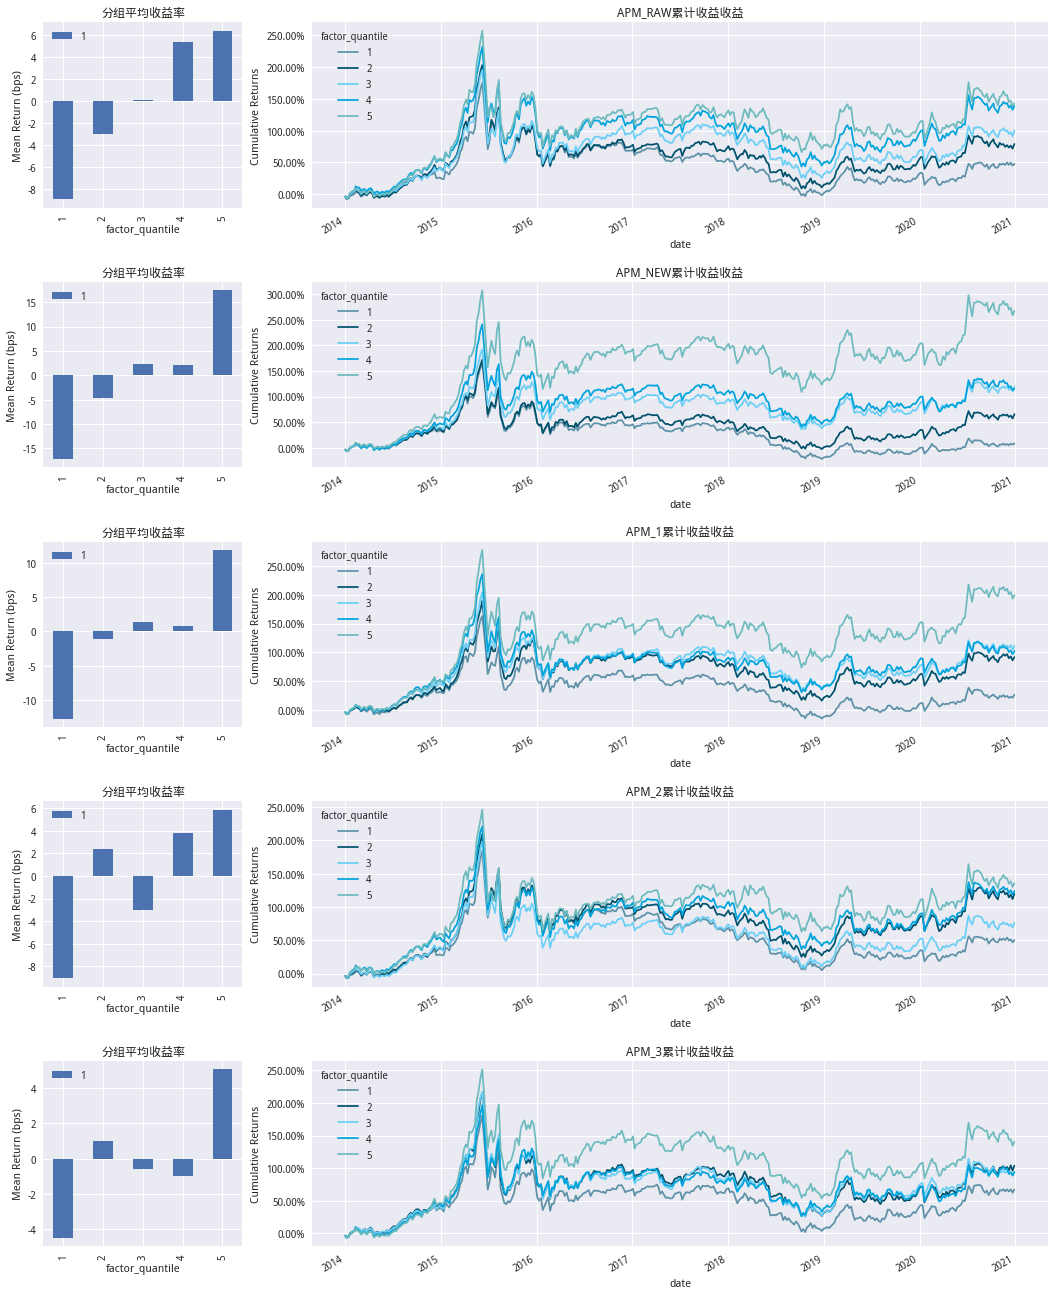

In [145]:
# 分组收益画图
rows = factor_data.shape[1]  # 组数

color_map = ['#5D91A7', '#00516C', '#6BCFF6', '#00A4DC', '#6DBBBF',
             '#008982']  # 设置颜色

# 设置图表大小
mpl.rcParams['font.family'] = 'serif'
fig = plt.figure(figsize=(18, 5 * rows))
gs = GridSpec(rows, 4, figure=fig)

for i, (factor_name, df) in enumerate(apm_ret_dic.items()):

    ax1 = plt.subplot(gs[i, :1])
    ax2 = plt.subplot(gs[i, 1:])

    # 计算分组平均收益
    mean_ret, _ = perf.mean_return_by_quantile(factor_dic[factor_name])
    mean_ret = mean_ret * 10000

    ax1.set_ylabel('Mean Return (bps)')
    mean_ret.plot.bar(ax=ax1, title='分组平均收益率')

    # 计算累计收益率
    ep.cum_returns(df).plot(ax=ax2,
                            title=f'{factor_name.upper()}累计收益收益',
                            color=color_map)

    ax2.set_ylabel('Cumulative Returns')
    ax2.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x * 100)))

    plt.subplots_adjust(hspace=0.4, wspace=0.35)


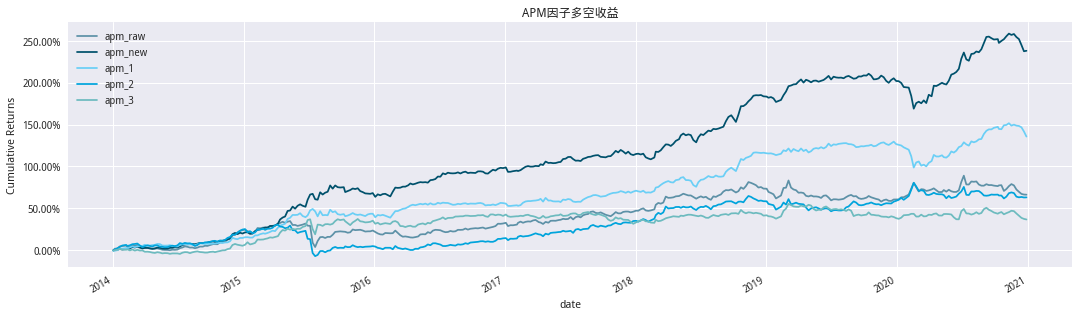

In [147]:
# 多空收益画图

color_map = ['#5D91A7', '#00516C', '#6BCFF6', '#00A4DC', '#6DBBBF',
             '#008982']  # 设置颜色

# 设置图表大小
mpl.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(18, 5))

excess_df = pd.concat(
    (ep.cum_returns(df[5] - df[1]) for df in apm_ret_dic.values()), axis=1)
excess_df.columns = list(apm_ret_dic.keys())

excess_df.plot(ax=ax, title='APM因子多空收益', color=color_map)
ax.set_ylabel('Cumulative Returns')
ax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x * 100)))

In [120]:
# 获取基准数据
benchmark = get_price('000905.XSHG',start_date='2014-01-01',end_date='2020-12-31',fields='close')
benchmark = benchmark.reindex(apm_ret_dic['apm_raw'].index)

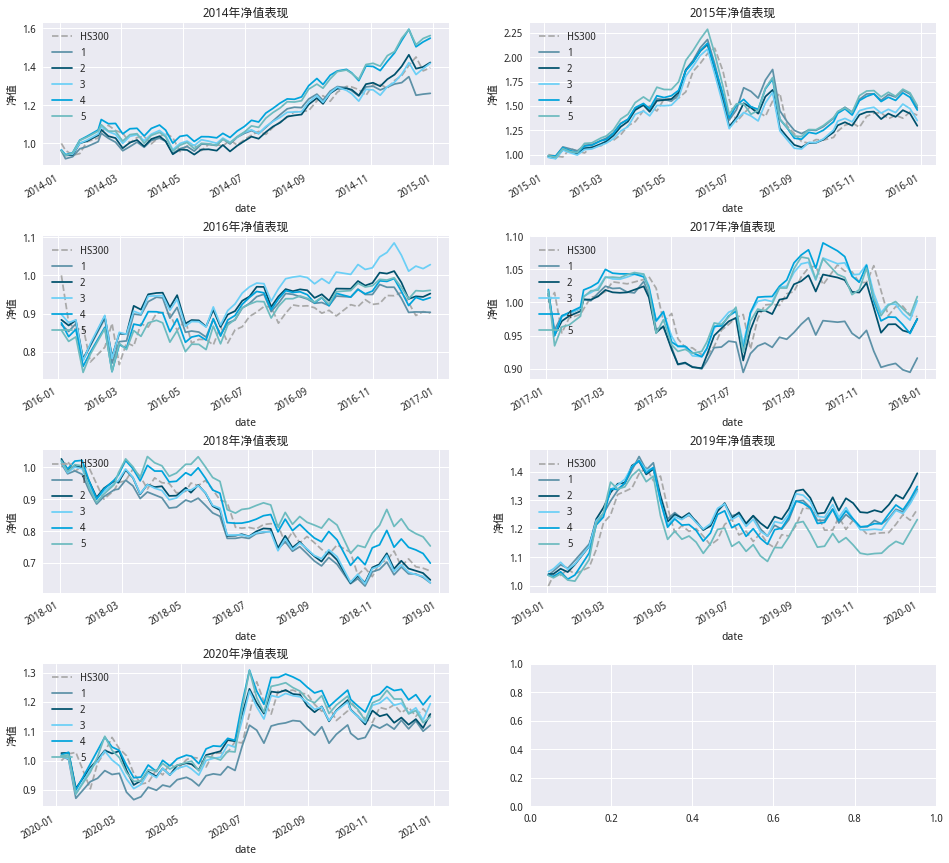

In [123]:
# APM_RAW因子的分年度表现
plot_algorithm_periods_nav(apm_ret_dic['apm_raw'],benchmark,color=color_map);

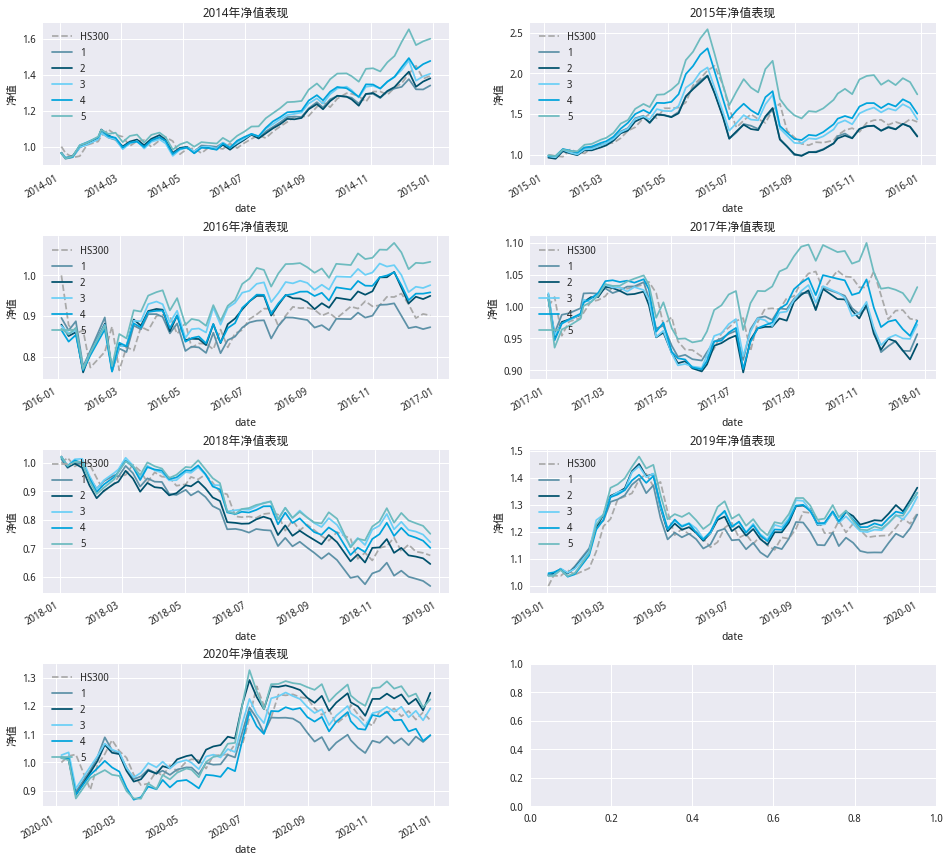

In [124]:
# APM_NEW改进因子的分年度表现
plot_algorithm_periods_nav(apm_ret_dic['apm_new'],benchmark,color=color_map);

# 因子IC表现

In [218]:
# 计算头部、底部分组组合的ic
top_ic_dic = {
    k: perf.factor_information_coefficient(f.query('factor_quantile == 5').fillna(0))
    for k, f in factor_dic.items()
}

bottom_ic_dic = {
    k: perf.factor_information_coefficient(f.query('factor_quantile == 1').fillna(0))
    for k, f in factor_dic.items()
}

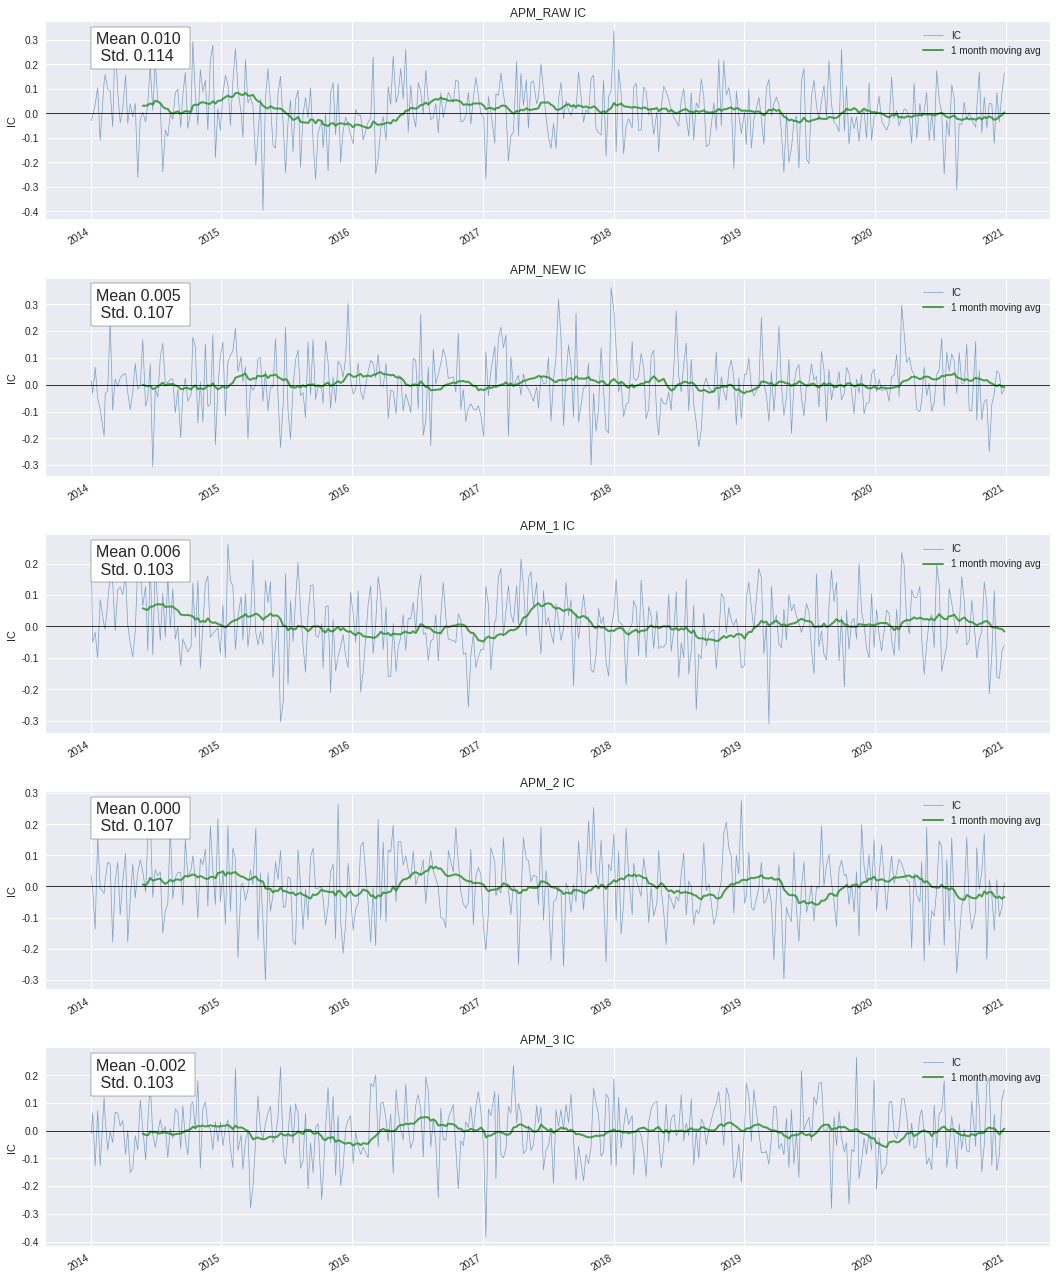

In [219]:
# 画IC
fig,axes = plt.subplots(rows,figsize=(18,5 * rows))

for ax,(factor_name,ic_ser) in zip(axes, top_ic_dic.items()):
    
    plotting.plot_ic_ts(ic_ser,[ax])
    ax.set_title(f'{factor_name.upper()} IC')
    plt.subplots_adjust(hspace=0.3)

In [220]:
# 头部IC
top_ic_tablet = pd.concat(
    (get_information_table(df.fillna(0)).T for df in top_ic_dic.values()), axis=1)

top_ic_tablet.columns = list(top_ic_dic.keys())

# 底部IC
bottom_ic_tablet = pd.concat(
    (get_information_table(df.fillna(0)).T for df in bottom_ic_dic.values()), axis=1)

bottom_ic_tablet.columns = list(bottom_ic_dic.keys())

In [221]:
# 头部组合
top_ic_tablet.apply(lambda x: x.round(3))

,apm_raw,apm_new,apm_1,apm_2,apm_3
IC Mean,0.010,0.005,0.006,0.000,-0.002
IC Std.,0.114,0.107,0.103,0.107,0.103
Risk-Adjusted IC,0.084,0.045,0.055,0.004,-0.023
t-stat(IC),1.601,0.854,1.053,0.085,-0.437
p-value(IC),0.110,0.393,0.293,0.932,0.662
IC Skew,-0.170,0.225,-0.091,-0.146,-0.180
IC Kurtosis,0.353,0.416,-0.252,-0.058,0.002


In [222]:
# 底部组合
bottom_ic_tablet.apply(lambda x: x.round(3))

,apm_raw,apm_new,apm_1,apm_2,apm_3
IC Mean,0.012,0.015,0.019,-0.002,-0.001
IC Std.,0.106,0.111,0.105,0.115,0.106
Risk-Adjusted IC,0.111,0.132,0.185,-0.015,-0.009
t-stat(IC),2.111,2.512,3.512,-0.284,-0.173
p-value(IC),0.035,0.012,0.001,0.776,0.863
IC Skew,-0.065,0.062,0.284,-0.084,0.029
IC Kurtosis,-0.034,0.016,0.344,-0.033,-0.519


# 因子T检验情况

In [20]:
# 计算头部、底部分组组合的tvalue
top_tvalue_dic = {
    k: factor_ttest(f.query('factor_quantile == 5').fillna(0))
    for k, f in factor_dic.items()
}

bottom_tvalue_dic = {
    k: factor_ttest(f.query('factor_quantile == 1').fillna(0))
    for k, f in factor_dic.items()
}

In [23]:
# 头部T值
top_tvalue_tablet = pd.concat(
    (get_ttest_table(df) for df in top_tvalue_dic.values()), axis=1)

top_tvalue_tablet.columns = list(top_tvalue_dic.keys())

# 底部T值
bottom_tvalue_tablet = pd.concat(
    (get_ttest_table(df) for df in bottom_tvalue_dic.values()), axis=1)

bottom_tvalue_tablet.columns = list(bottom_tvalue_dic.keys())

In [24]:
# 头部
top_tvalue_tablet.apply(lambda x: x.round(3))

,apm_raw,apm_new,apm_1,apm_2,apm_3
Abs T Mean,1.104,1.044,1.106,1.105,1.086
T Mean,0.161,-0.178,-0.038,-0.065,-0.145
T > 2,0.158,0.114,0.122,0.144,0.136


In [25]:
# 底部
bottom_tvalue_tablet.apply(lambda x: x.round(3))

,apm_raw,apm_new,apm_1,apm_2,apm_3
Abs T Mean,0.973,1.003,1.125,0.997,1.132
T Mean,0.425,0.446,0.294,0.249,-0.159
T > 2,0.114,0.100,0.136,0.111,0.150


# 因子分组换手率

In [151]:
# 换手率相关计算
quantile_turnover = pd.concat(
    (perf.quantile_turnover(factor_dic['apm_new']['factor_quantile'], q, 1)
     for q in range(1, 6)),
    axis=1)

autocorrelation = perf.factor_rank_autocorrelation(factor_dic['apm_new'], 1)

Turnover Analysis


,apm_new
Quantile 1 Mean Turnover,0.354
Quantile 2 Mean Turnover,0.622
Quantile 3 Mean Turnover,0.664
Quantile 4 Mean Turnover,0.622
Quantile 5 Mean Turnover,0.366


,apm_new
Mean Factor Rank Autocorrelation,0.771


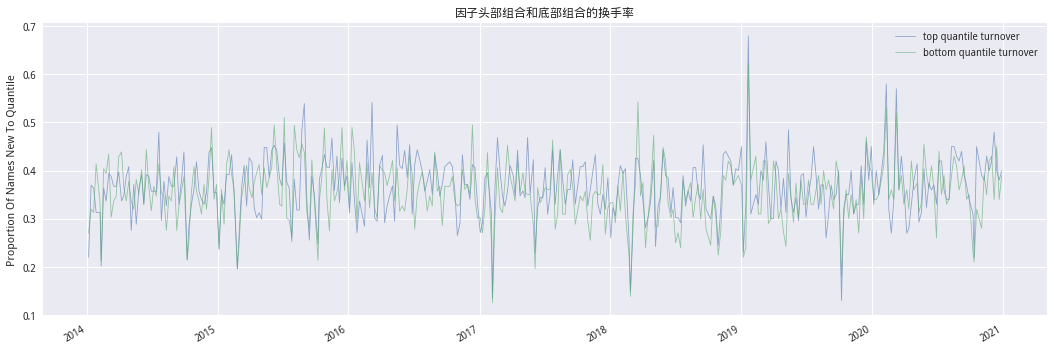

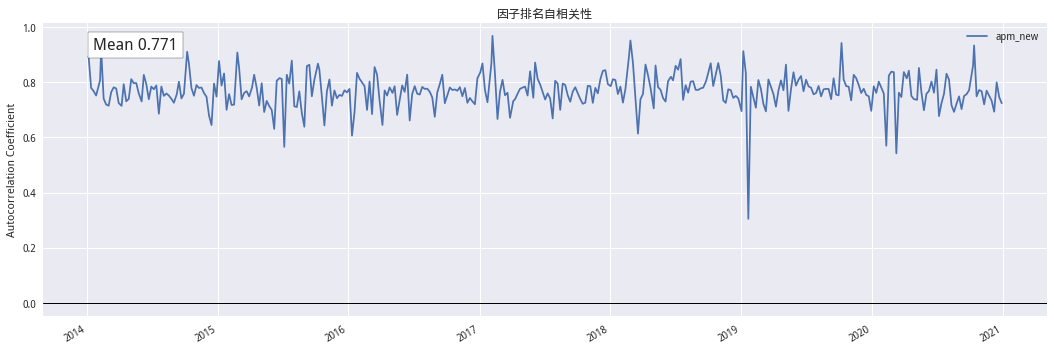

In [167]:
# 分组换手率及排名自相关性
plotting.plot_turnover_table(autocorrelation.to_frame('apm_new'), {'apm_new':quantile_turnover})

plotting.plot_top_bottom_quantile_turnover(quantile_turnover)
plt.title('因子头部组合和底部组合的换手率');

plotting.plot_factor_rank_auto_correlation(autocorrelation.to_frame('apm_new'))
plt.legend(loc='upper right')
plt.title('因子排名自相关性');